# Importing Packages

In [1]:
import pandas as pd
import numpy as np
import missingno
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from xgboost import XGBClassifier,plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split,KFold, GroupKFold, StratifiedKFold
import warnings
import plotly.express as px

warnings.filterwarnings("ignore")

# Importing Data

In [2]:
train = pd.read_csv("../input/tabular-playground-series-may-2021/train.csv")
test = pd.read_csv("../input/tabular-playground-series-may-2021/test.csv")

In [3]:
train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2


In [4]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

# **EDA**

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   feature_0   100000 non-null  int64 
 1   feature_1   100000 non-null  int64 
 2   feature_2   100000 non-null  int64 
 3   feature_3   100000 non-null  int64 
 4   feature_4   100000 non-null  int64 
 5   feature_5   100000 non-null  int64 
 6   feature_6   100000 non-null  int64 
 7   feature_7   100000 non-null  int64 
 8   feature_8   100000 non-null  int64 
 9   feature_9   100000 non-null  int64 
 10  feature_10  100000 non-null  int64 
 11  feature_11  100000 non-null  int64 
 12  feature_12  100000 non-null  int64 
 13  feature_13  100000 non-null  int64 
 14  feature_14  100000 non-null  int64 
 15  feature_15  100000 non-null  int64 
 16  feature_16  100000 non-null  int64 
 17  feature_17  100000 non-null  int64 
 18  feature_18  100000 non-null  int64 
 19  feature_19  100000 non-n

1. Column names doesn't make much sense as all of columns are named by integer with prefix as feature.so from domain stand-point, cannot interpret much information from column names.
1. No missing values in the dataset
1. All the columns are of type integer

# Missing Values

In [6]:
train.isnull().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
target        0
dtype: int64

In [7]:
test.isnull().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
dtype: int64

# Target Distribution

In [8]:
fig = px.histogram(train, x=train['target'], color=train['target'],)
fig.update_layout(
    title_text='Target distribution', # title of plot
    xaxis_title_text='Value', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    
)
fig.show()

### In the target variable, Class2 has more data points compared to the remaining labels.

# Correlation Matrix

In [9]:
rename_labels = {val:idx for idx, val in enumerate(sorted(train['target'].unique()))}
train['target'] = train['target'].map(rename_labels)

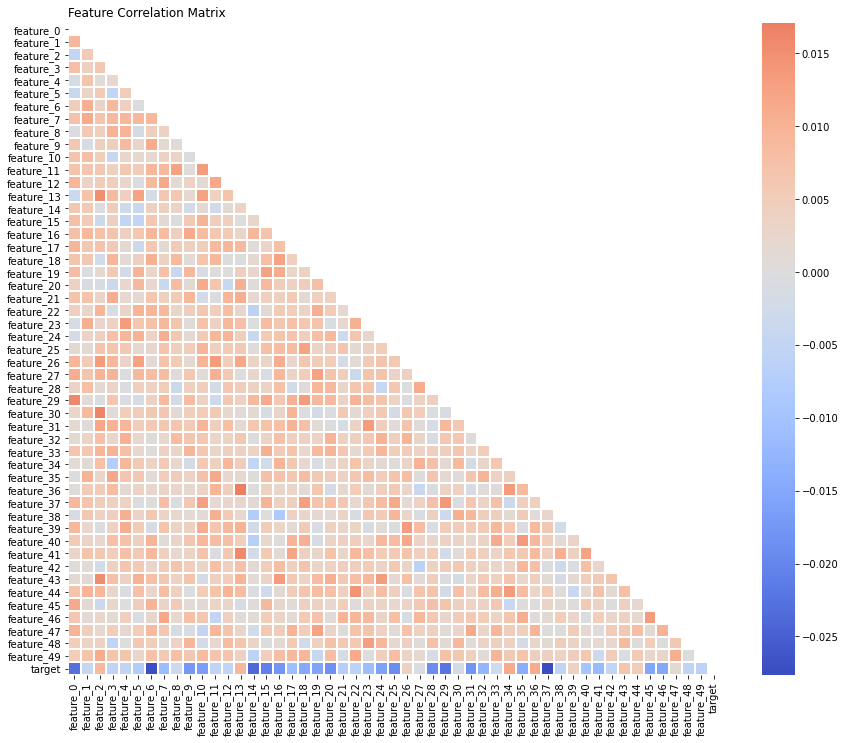

In [10]:
fig, ax = plt.subplots(figsize=(15 , 12))
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr,square=True, center=0, 
            linewidth=0.2, cmap='coolwarm',
           mask=mask, ax=ax) 

ax.set_title('Feature Correlation Matrix ', loc='left')
plt.show()

In [11]:
train.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000
mean,0.257830,0.431720,0.114130,0.590550,0.599770,0.160820,0.731490,1.228920,0.903350,0.940120,...,0.582070,0.529230,0.616310,0.135100,0.358660,0.516810,0.39004,0.970850,0.55712,1.381160
std,0.929033,1.977862,0.519584,1.844558,2.785531,0.601149,2.343465,2.692732,3.415258,1.904172,...,2.003114,2.300826,2.360955,0.627592,1.464187,2.171415,1.48735,2.576615,1.68093,0.810891
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.00000,2.000000
max,10.000000,31.000000,6.000000,26.000000,38.000000,10.000000,27.000000,31.000000,39.000000,17.000000,...,32.000000,37.000000,33.000000,9.000000,26.000000,29.000000,25.00000,44.000000,20.00000,3.000000


1. The mean of the all the features are closer to zero.
1. There is low variance across all the features.
1. The median is mostly 0 except two columns

# Number of features Unique Values

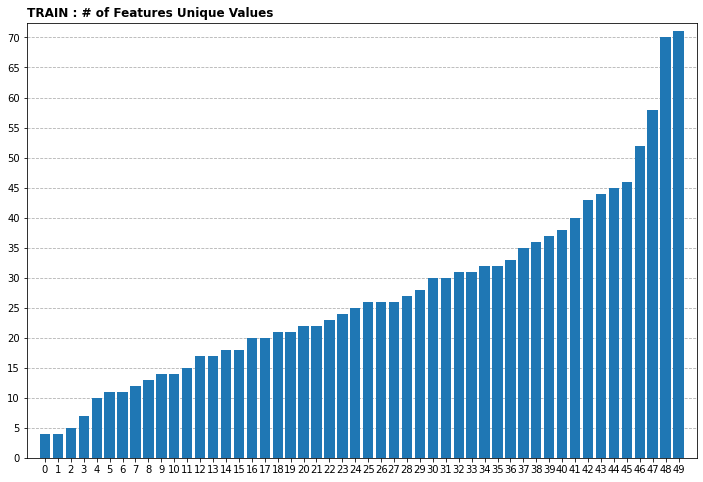

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

# x = [f'feature_{i}' for i in range(50)]
y = sorted([len(train[f'feature_{i}'].unique()) for i in range(50)])

ax.bar(range(50), y, zorder=10)
ax.set_xticks(range(50))
ax.set_yticks(range(0, 80, 5))
ax.margins(0.02)

ax.set_title('TRAIN : # of Features Unique Values', loc='left', fontweight='bold')
ax.grid(axis='y', linestyle='--', zorder=5)
plt.show()

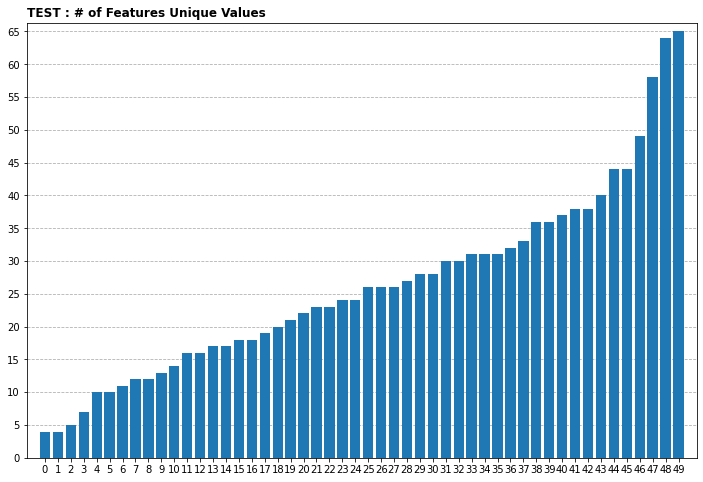

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

# x = [f'feature_{i}' for i in range(50)]
y = sorted([len(test[f'feature_{i}'].unique()) for i in range(50)])

ax.bar(range(50), y, zorder=10)
ax.set_xticks(range(50))
ax.set_yticks(range(0, 80, 5))
ax.margins(0.02)

ax.set_title('TEST : # of Features Unique Values', loc='left', fontweight='bold')
ax.grid(axis='y', linestyle='--', zorder=5)
plt.show()

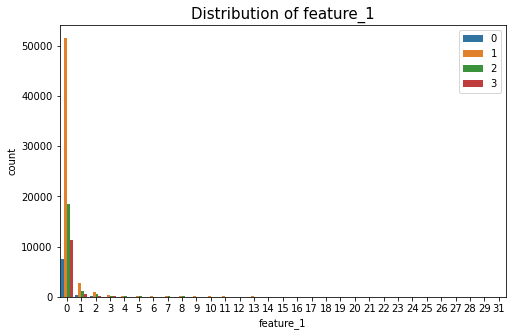

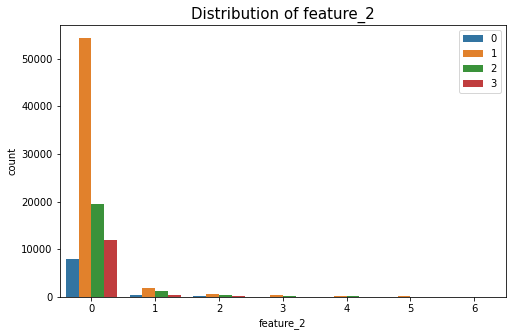

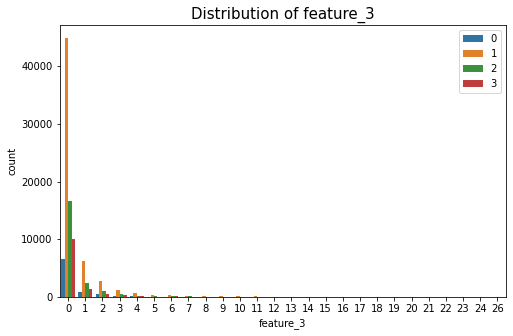

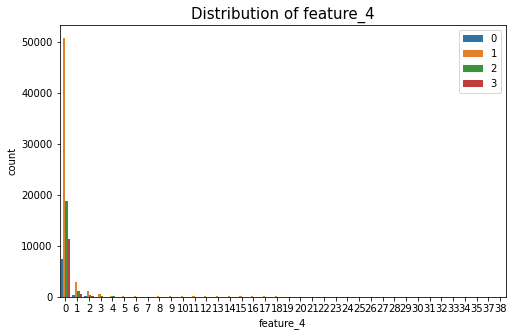

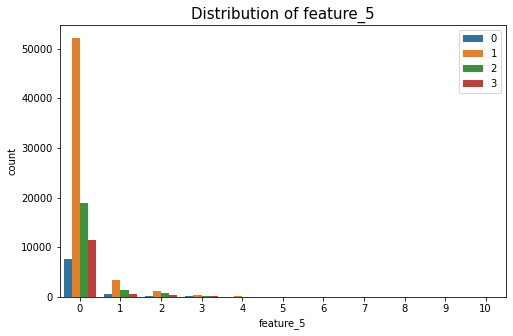

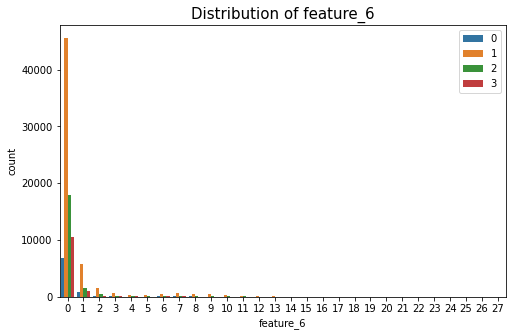

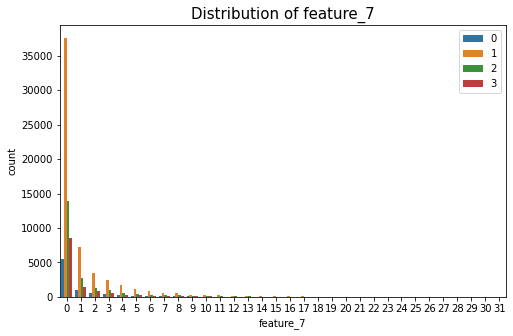

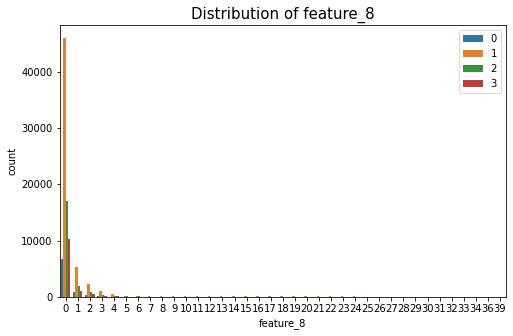

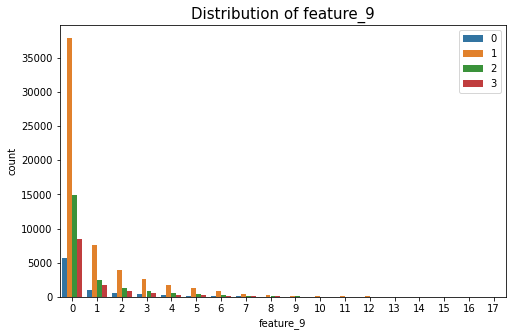

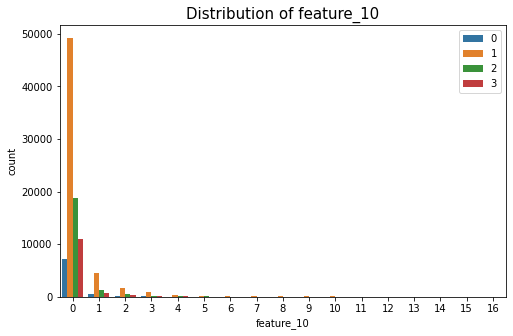

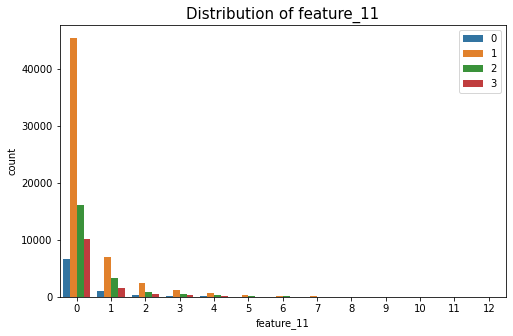

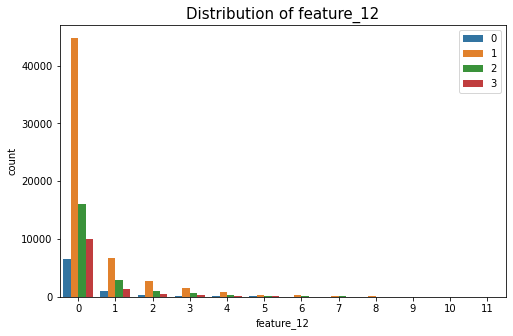

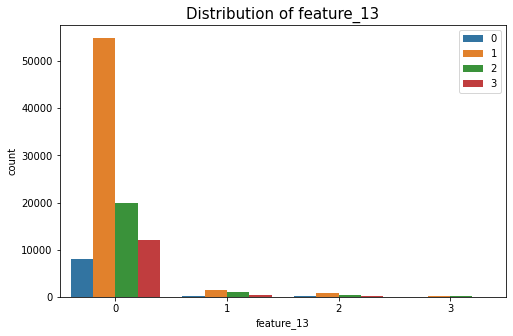

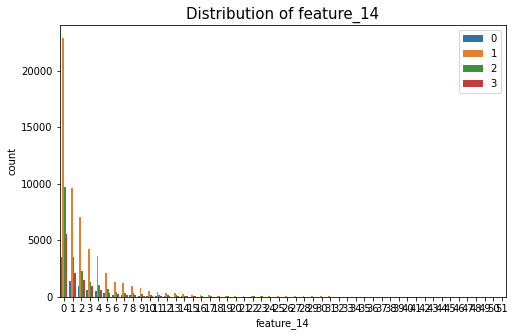

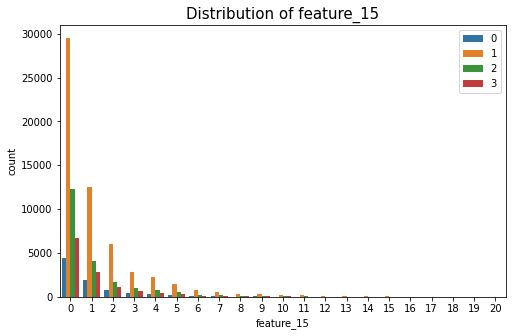

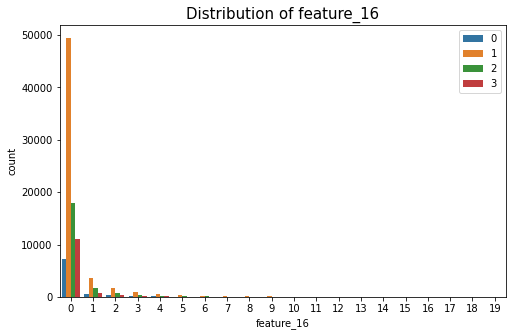

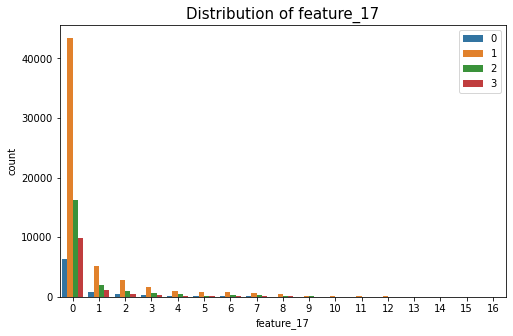

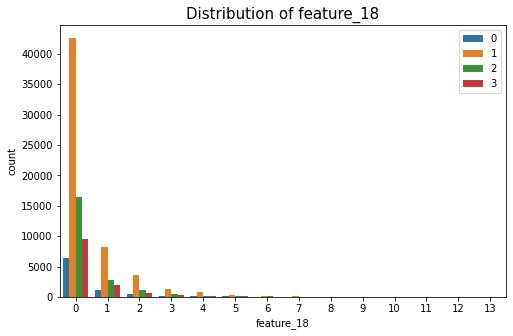

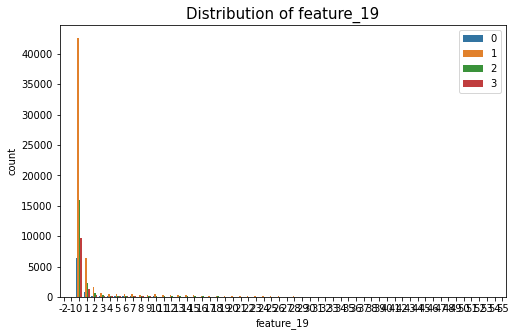

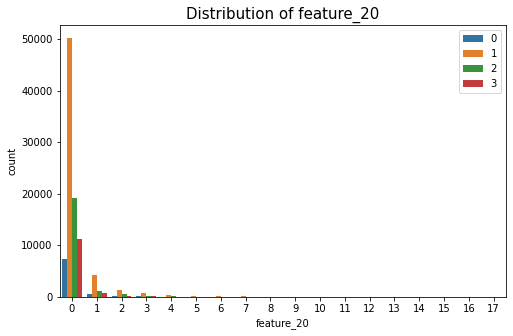

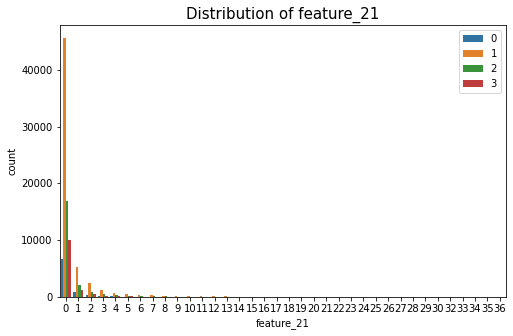

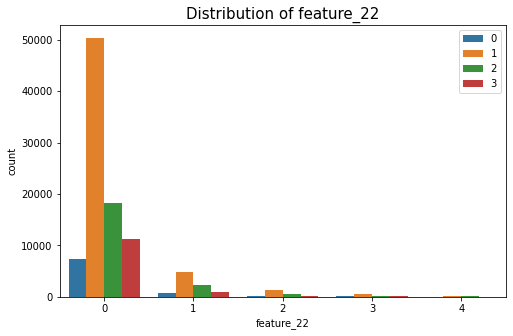

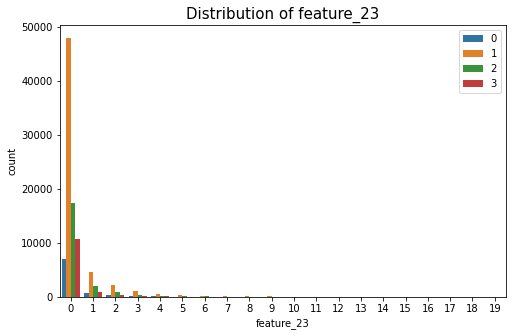

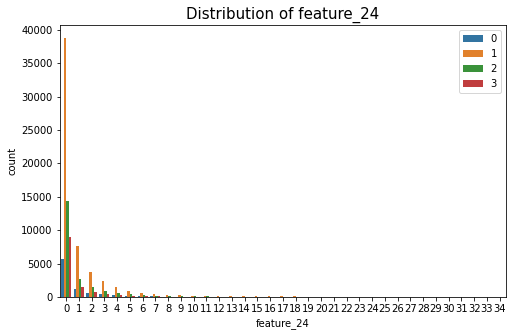

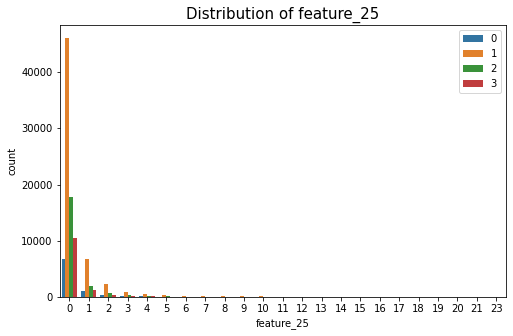

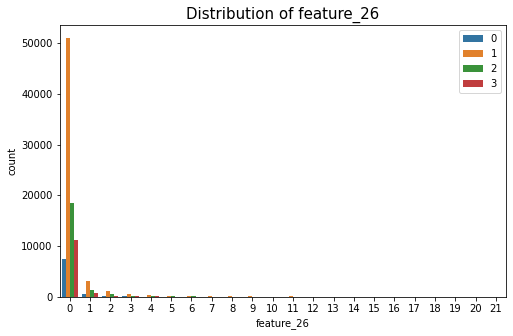

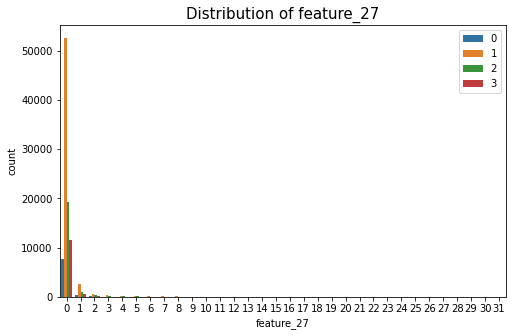

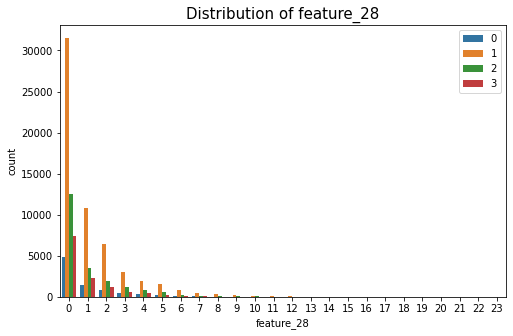

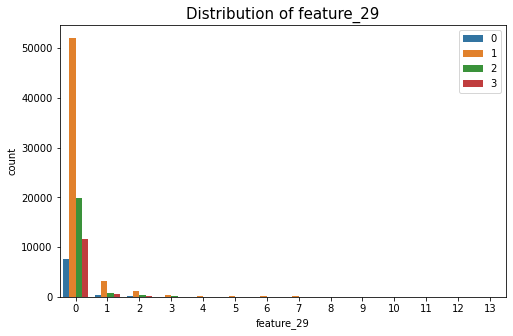

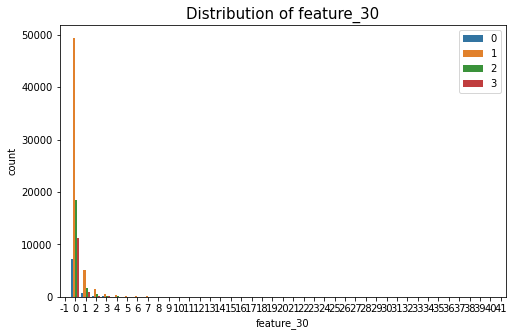

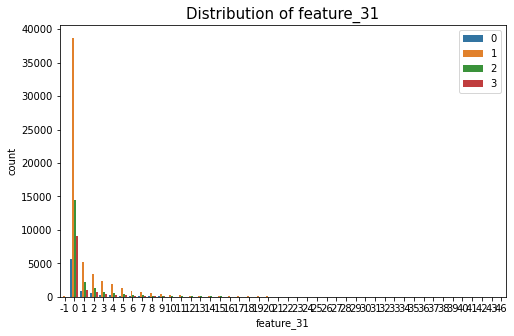

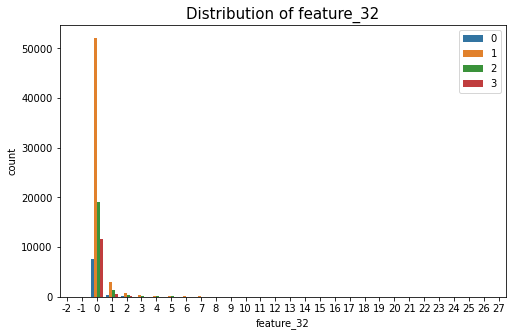

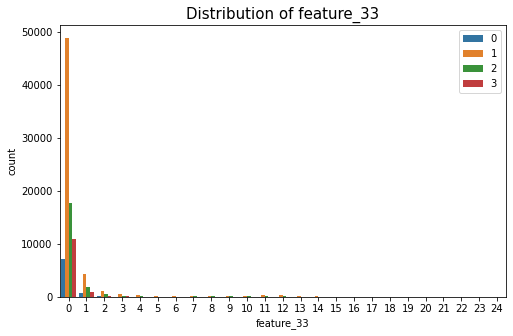

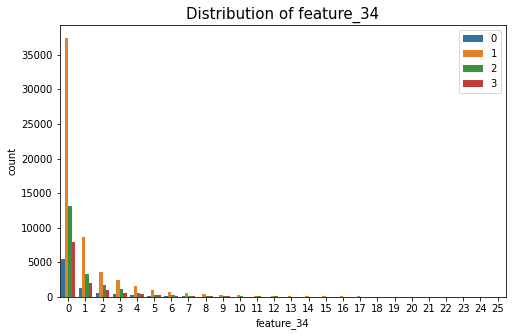

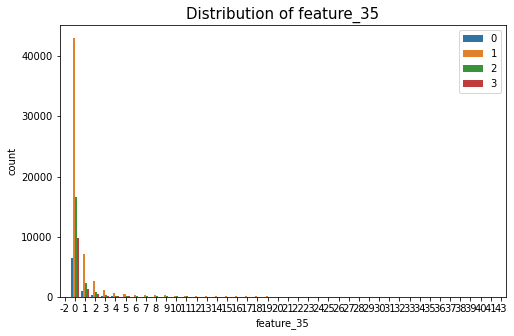

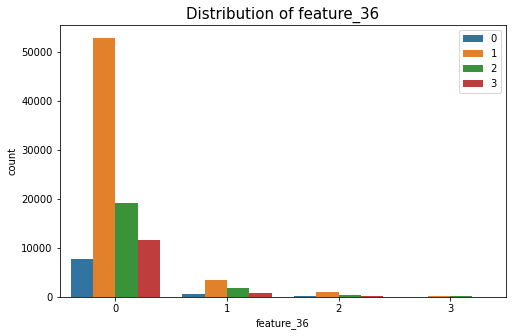

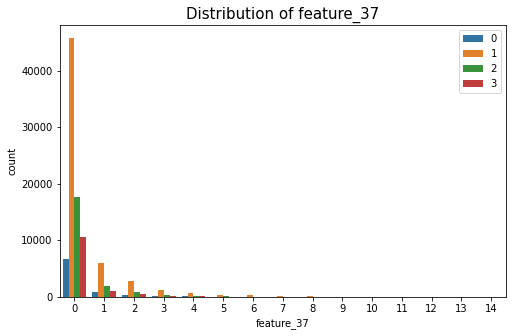

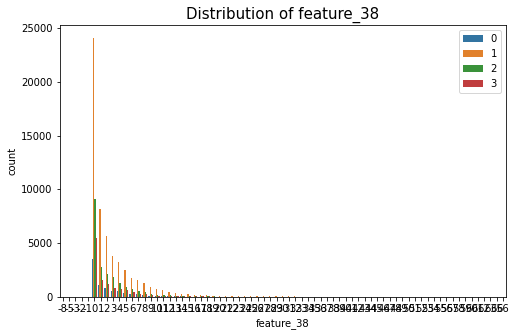

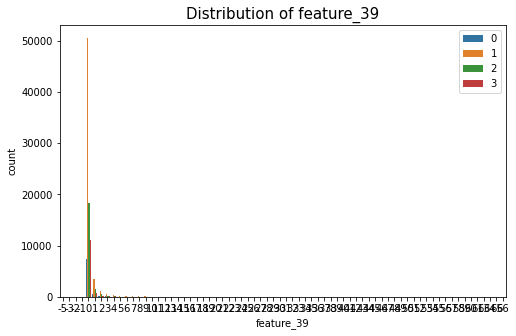

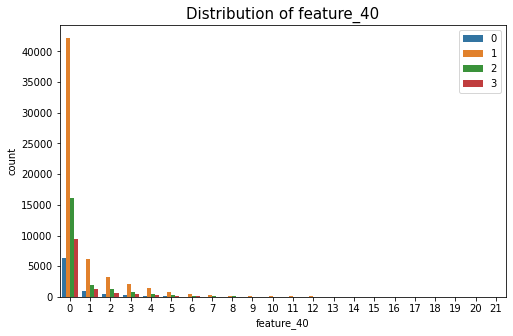

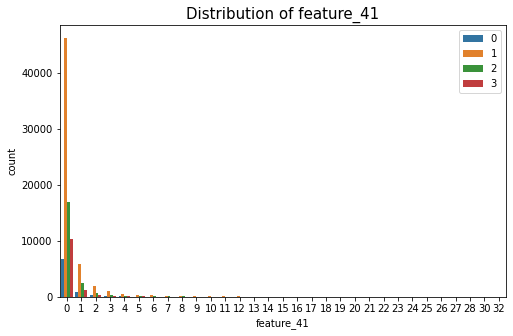

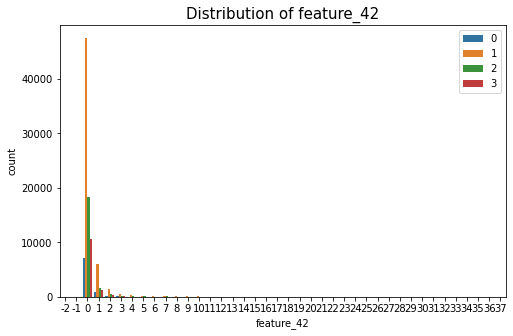

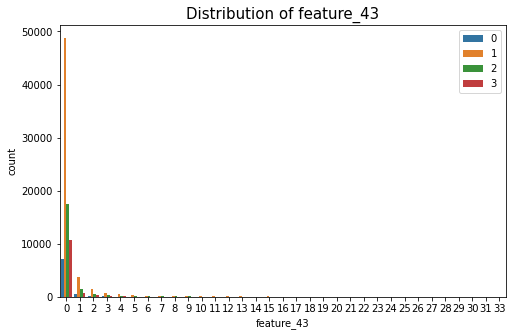

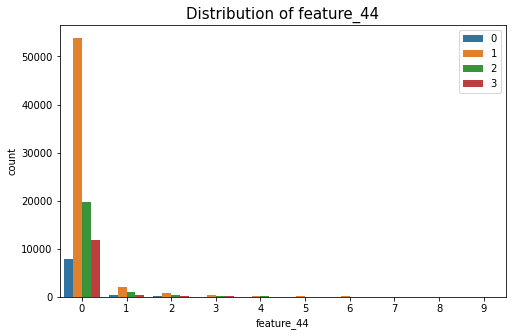

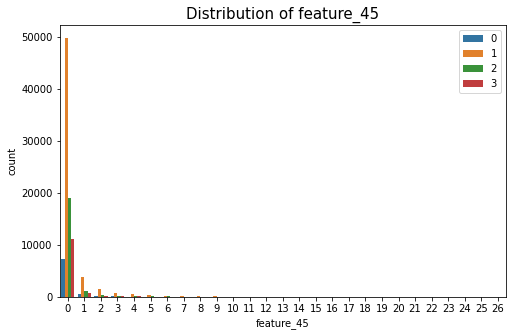

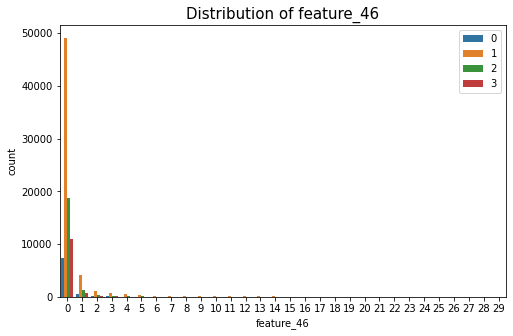

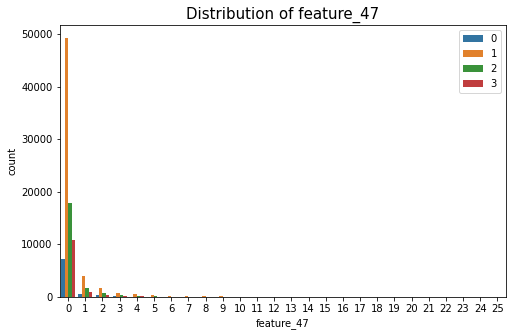

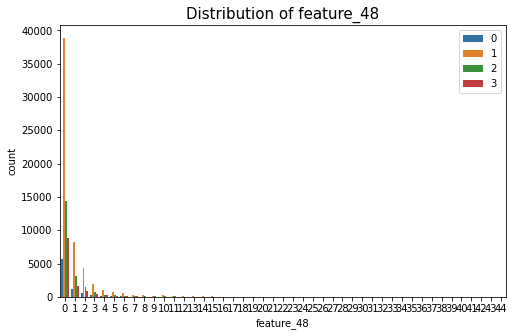

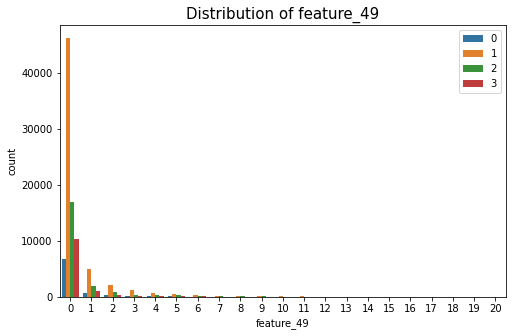

In [14]:
train_p = train
lic = []
for col in train_p.columns[1:-1]:
    lic.append(col)
    
def plot(col):
    plt.figure(figsize = (8,5))
    g = sns.countplot(x = col, hue = 'target', data = train_p)
    plt.legend(loc='upper right')
    plt.title("Distribution of "+ col,fontsize=15)
    plt.show();

for col in lic:
    plot(col)

# Outliers

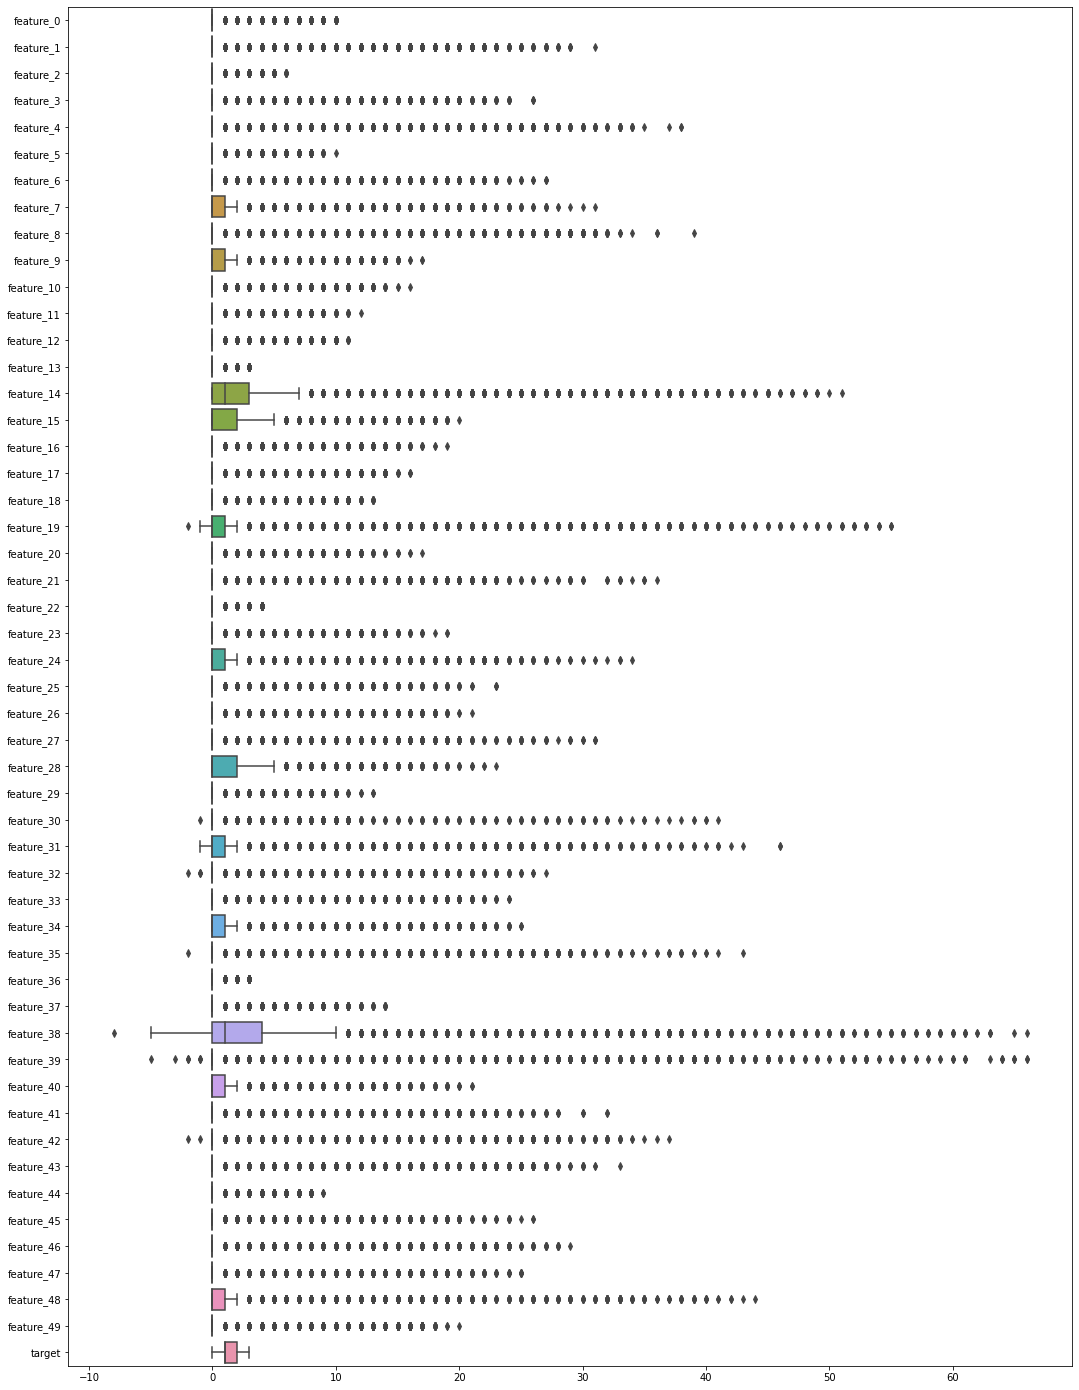

In [15]:
plt.figure(figsize=(18,25))
sns.boxplot(data=train, orient="h");

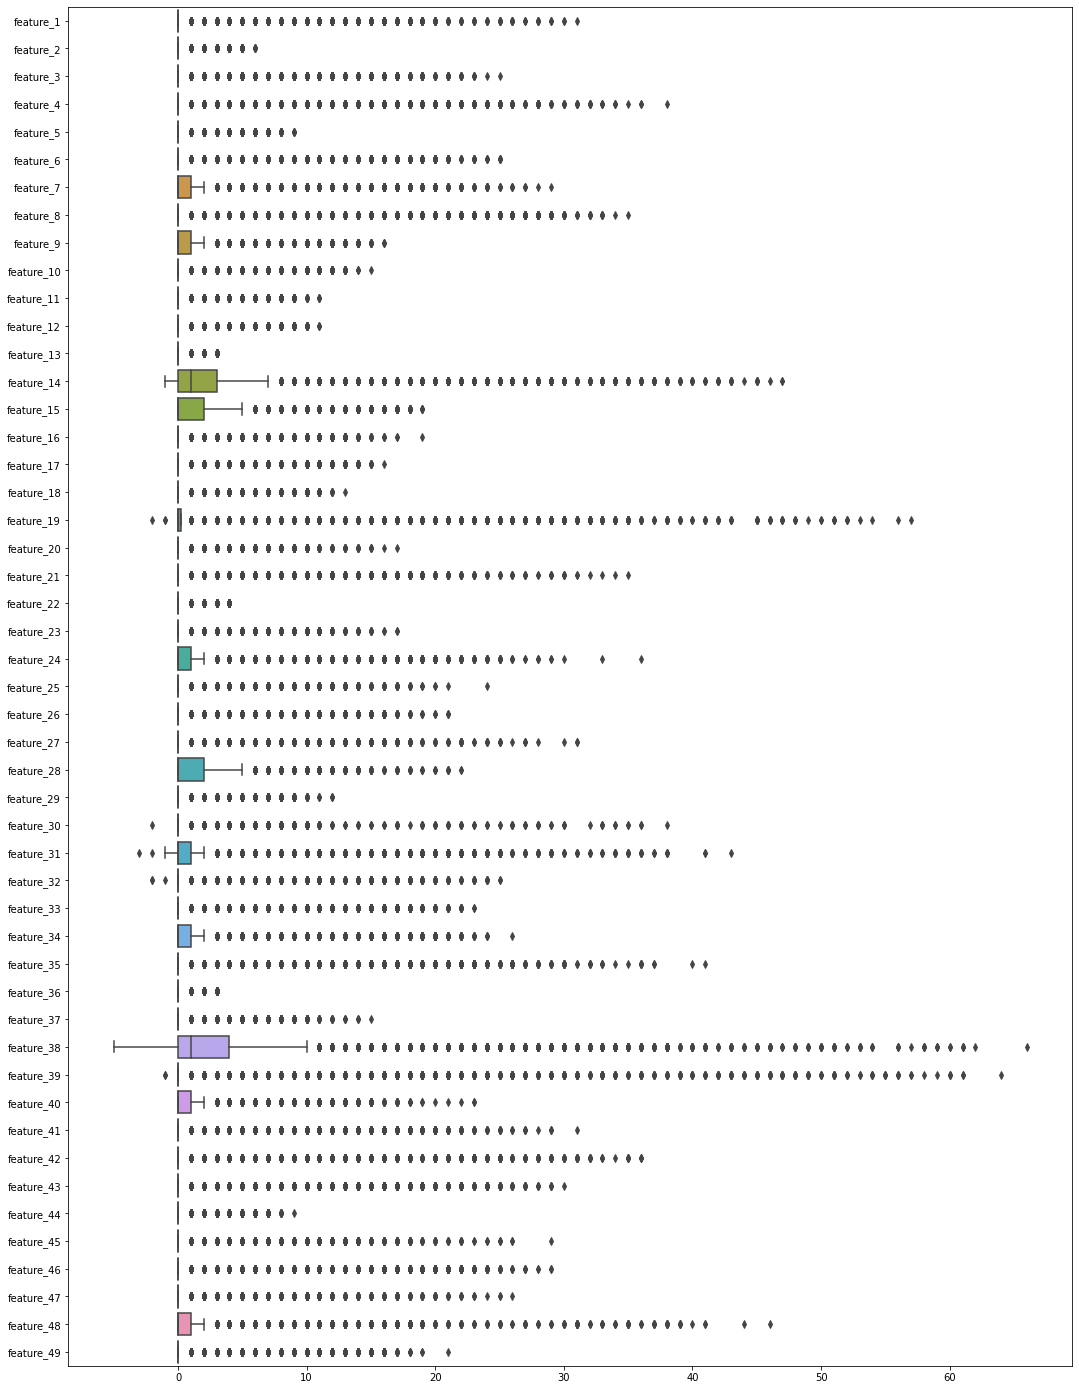

In [16]:
plt.figure(figsize=(18,25))
sns.boxplot(data=test.iloc[:,1:], orient="h");

In [17]:
le = LabelEncoder()
train['target'] = le.fit_transform(train['target'])

In [18]:
train.columns

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',
       'target'],
      dtype='object')

In [19]:
cols = list(train.columns)
cols.remove("target")

# Feature Importance using XGBoost default Parameters

In [20]:
model = XGBClassifier(tree_method = 'gpu_hist' ,
                      use_label_encoder=False)
model.fit(train.drop(columns='target'),train.target)

[04:07:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

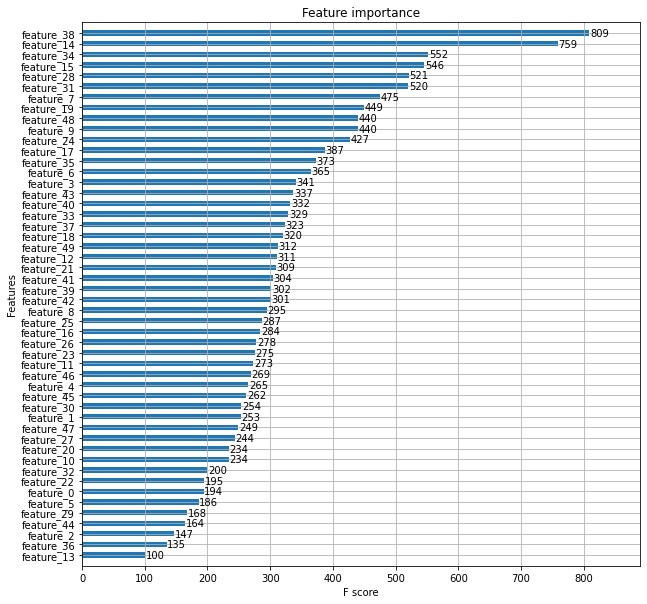

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(model,
                height=0.5,
               max_num_features=None,
               title='Feature importance',
                xlabel='F score', 
                ylabel='Features',
               ax=ax)

# XGBoost

In [22]:
xgb_params = {
     "seed":42,
    "n_estimators":10000,
    "verbosity":1,
    "eval_metric":"mlogloss",
    "alpha":7.105038963844129,
    "colsample_bytree":0.25505629740052566,
    "gamma":0.4999381950212869,
    "reg_lambda":1.7256912198205319,
    "learning_rate":0.011823142071967673,
    "max_bin":338,
    "max_depth":8,
    "min_child_weight":2.286836198630466,
    "subsample":0.618417952155855,
    'tree_method':'gpu_hist',
    'gpu_id':0
}
xgb_params['interaction_constraints'] = '[[38, 14], [34, 14, 31], [15, 19]]'

In [23]:
test_preds = None
train_rmse = 0
val_rmse = 0
n_splits = 10

kf = KFold(n_splits = n_splits , shuffle = True , random_state = 0)
for fold, (tr_index , val_index) in enumerate(kf.split(train[cols].values , train['target'].values)):
    
    print("-" * 50)
    print(f"Fold {fold + 1}")
    
    x_train,x_val = train[cols].values[tr_index] , train[cols].values[val_index]
    y_train,y_val = train['target'].values[tr_index] , train['target'].values[val_index]
        
    eval_set = [(x_val, y_val)]
    
    model =XGBClassifier(**xgb_params)
    model.fit(x_train, y_train, eval_set = eval_set, verbose = 500)
    
    train_preds = model.predict(x_train)
    train_rmse += mean_squared_error(y_train ,train_preds , squared = False)
    print("Training RMSE : " , mean_squared_error(y_train ,train_preds , squared = False))
    
    val_preds = model.predict(x_val)
    val_rmse += mean_squared_error(y_val , val_preds , squared = False)
    print("Validation RMSE : " , mean_squared_error(y_val , val_preds , squared = False))
    
    if test_preds is None:
        test_preds = model.predict_proba(test[cols].values)
    else:
        test_preds += model.predict_proba(test[cols].values)

print("-" * 50)
print("Average Training RMSE : " , train_rmse / n_splits)
print("Average Validation RMSE : " , val_rmse / n_splits)

test_preds /= n_splits

--------------------------------------------------
Fold 1
[0]	validation_0-mlogloss:1.38159
[500]	validation_0-mlogloss:1.11178
[1000]	validation_0-mlogloss:1.10655
[1500]	validation_0-mlogloss:1.10292
[2000]	validation_0-mlogloss:1.10032
[2500]	validation_0-mlogloss:1.09841
[3000]	validation_0-mlogloss:1.09696
[3500]	validation_0-mlogloss:1.09584
[4000]	validation_0-mlogloss:1.09500
[4500]	validation_0-mlogloss:1.09432
[5000]	validation_0-mlogloss:1.09381
[5500]	validation_0-mlogloss:1.09345
[6000]	validation_0-mlogloss:1.09314
[6500]	validation_0-mlogloss:1.09291
[7000]	validation_0-mlogloss:1.09275
[7500]	validation_0-mlogloss:1.09264
[8000]	validation_0-mlogloss:1.09255
[8500]	validation_0-mlogloss:1.09248
[9000]	validation_0-mlogloss:1.09242
[9500]	validation_0-mlogloss:1.09242
[9999]	validation_0-mlogloss:1.09244
Training RMSE :  0.8914781732231772
Validation RMSE :  0.8954886933959579
--------------------------------------------------
Fold 2
[0]	validation_0-mlogloss:1.38161
[50

In [24]:
submission = pd.read_csv("../input/tabular-playground-series-may-2021/sample_submission.csv")
submission['Class_1']=test_preds[:,0]
submission['Class_2']=test_preds[:,1]
submission['Class_3']=test_preds[:,2]
submission['Class_4']=test_preds[:,3]
submission.head()

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.100468,0.627492,0.150796,0.121244
1,100001,0.074136,0.713948,0.122414,0.089502
2,100002,0.085550,0.651802,0.170160,0.092487
3,100003,0.085340,0.522532,0.321484,0.070644
4,100004,0.077504,0.623303,0.189862,0.109331


In [25]:
submission.to_csv("XGB.csv",index=False)

# CatBoost

In [26]:
test_preds = None
train_rmse = 0
val_rmse = 0
n_splits = 10

kf = KFold(n_splits = n_splits , shuffle = True , random_state = 0)
for fold, (tr_index , val_index) in enumerate(kf.split(train[cols].values , train['target'].values)):
    
    print("-" * 50)
    print(f"Fold {fold + 1}")
    
    x_train,x_val = train[cols].values[tr_index] , train[cols].values[val_index]
    y_train,y_val = train['target'].values[tr_index] , train['target'].values[val_index]
        
    eval_set = [(x_val, y_val)]
    
    model = CatBoostClassifier(depth=4,
                               task_type="GPU",
            max_ctr_complexity=15,
            iterations=50000,
            od_wait=1000, od_type='Iter',
            learning_rate=0.01,
            min_data_in_leaf=1,
            use_best_model=True,
            loss_function='MultiClass')
    model.fit(x_train, y_train, eval_set = eval_set, verbose = 500)
    
    train_preds = model.predict(x_train)
    train_rmse += mean_squared_error(y_train ,train_preds , squared = False)
    print("Training RMSE : " , mean_squared_error(y_train ,train_preds , squared = False))
    
    val_preds = model.predict(x_val)
    val_rmse += mean_squared_error(y_val , val_preds , squared = False)
    print("Validation RMSE : " , mean_squared_error(y_val , val_preds , squared = False))
    
    if test_preds is None:
        test_preds = model.predict_proba(test[cols].values)
    else:
        test_preds += model.predict_proba(test[cols].values)

print("-" * 50)
print("Average Training RMSE : " , train_rmse / n_splits)
print("Average Validation RMSE : " , val_rmse / n_splits)

test_preds /= n_splits

--------------------------------------------------
Fold 1
0:	learn: 1.3802262	test: 1.3802577	best: 1.3802577 (0)	total: 13.8ms	remaining: 11m 30s
500:	learn: 1.1007878	test: 1.1054167	best: 1.1054167 (500)	total: 3.22s	remaining: 5m 17s
1000:	learn: 1.0935552	test: 1.1001396	best: 1.1001396 (1000)	total: 6.17s	remaining: 5m 2s
1500:	learn: 1.0889639	test: 1.0972566	best: 1.0972566 (1500)	total: 9.11s	remaining: 4m 54s
2000:	learn: 1.0856516	test: 1.0956705	best: 1.0956705 (2000)	total: 12.5s	remaining: 4m 58s
2500:	learn: 1.0829306	test: 1.0946444	best: 1.0946444 (2500)	total: 15.4s	remaining: 4m 51s
3000:	learn: 1.0806409	test: 1.0939931	best: 1.0939931 (3000)	total: 19s	remaining: 4m 57s
3500:	learn: 1.0785870	test: 1.0935706	best: 1.0935701 (3489)	total: 22.4s	remaining: 4m 56s
4000:	learn: 1.0767626	test: 1.0932358	best: 1.0932321 (3997)	total: 25.3s	remaining: 4m 50s
4500:	learn: 1.0750742	test: 1.0929736	best: 1.0929729 (4499)	total: 28.1s	remaining: 4m 44s
5000:	learn: 1.073454

In [27]:
submission1 = pd.read_csv("../input/tabular-playground-series-may-2021/sample_submission.csv")
submission1['Class_1']=test_preds[:,0]
submission1['Class_2']=test_preds[:,1]
submission1['Class_3']=test_preds[:,2]
submission1['Class_4']=test_preds[:,3]
submission1.head()

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.091753,0.619235,0.167259,0.121752
1,100001,0.079515,0.702991,0.133115,0.084380
2,100002,0.085338,0.636188,0.177314,0.101160
3,100003,0.083832,0.543836,0.277166,0.095167
4,100004,0.074619,0.612739,0.191163,0.121479


In [28]:
submission1.to_csv("CB.csv",index=False)

# H2O AutoML

In [29]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-may-2021/train.csv')
train_df.columns = [column.lower() for column in train_df.columns]

test_df = pd.read_csv('/kaggle/input/tabular-playground-series-may-2021/test.csv')
test_df.columns = [column.lower() for column in test_df.columns]

submission = pd.read_csv('/kaggle/input/tabular-playground-series-may-2021/sample_submission.csv')

In [30]:
feature_columns = train_df.iloc[:, 1:-1].columns.values
target_column = 'target'
feature_columns

array(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13',
       'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'feature_19', 'feature_20', 'feature_21',
       'feature_22', 'feature_23', 'feature_24', 'feature_25',
       'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33',
       'feature_34', 'feature_35', 'feature_36', 'feature_37',
       'feature_38', 'feature_39', 'feature_40', 'feature_41',
       'feature_42', 'feature_43', 'feature_44', 'feature_45',
       'feature_46', 'feature_47', 'feature_48', 'feature_49'],
      dtype=object)

In [31]:
import h2o
from h2o.automl import H2OAutoML

In [32]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7pf3lb10
  JVM stdout: /tmp/tmp7pf3lb10/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp7pf3lb10/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_unknownUser_gpzqo1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.250 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [33]:
train_hf = h2o.H2OFrame(train_df.copy())
test_hf = h2o.H2OFrame(test_df.copy())

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [34]:
train_hf[target_column] = train_hf[target_column].asfactor()

In [35]:
%%time
aml = H2OAutoML(
    seed=2021, 
    max_runtime_secs=600,
    nfolds = 3
)

aml.train(
    x=list(feature_columns), 
    y=target_column, 
    training_frame=train_hf
)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 1min 30s, sys: 1.62 s, total: 1min 32s
Wall time: 10min 39s


In [36]:
lb = aml.leaderboard 
lb.head(rows = lb.nrows)

model_id,mean_per_class_error,logloss,rmse,mse,auc,aucpr
XGBoost_grid__1_AutoML_20210511_045804_model_1,0.734015,1.11068,0.626506,0.39251,nan,nan
StackedEnsemble_AllModels_AutoML_20210511_045804,0.738533,1.0944,0.625552,0.391315,nan,nan
StackedEnsemble_BestOfFamily_AutoML_20210511_045804,0.740903,1.09771,0.626924,0.393033,nan,nan
XGBoost_2_AutoML_20210511_045804,0.742954,1.16929,0.67522,0.455923,nan,nan
XRT_1_AutoML_20210511_045804,0.743615,1.52047,0.637809,0.406801,nan,nan
DRF_1_AutoML_20210511_045804,0.743617,2.36731,0.6458,0.417057,nan,nan
XGBoost_1_AutoML_20210511_045804,0.743968,1.11149,0.639601,0.40909,nan,nan
DeepLearning_grid__1_AutoML_20210511_045804_model_1,0.74617,1.11612,0.627804,0.394138,nan,nan
GBM_grid__1_AutoML_20210511_045804_model_2,0.746224,1.19694,0.687878,0.473177,nan,nan
GBM_4_AutoML_20210511_045804,0.746744,1.26086,0.713012,0.508386,nan,nan


In [37]:
%%time

preds = aml.predict(h2o.H2OFrame(test_df[feature_columns].copy()))
preds_df = h2o.as_list(preds)
preds_df

submission[['Class_1', 'Class_2', 'Class_3', 'Class_4']] = preds_df[['Class_1', 'Class_2', 'Class_3', 'Class_4']]
submission.to_csv('H2o_Automl.csv', index=False)
submission.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
CPU times: user 1.92 s, sys: 46.5 ms, total: 1.97 s
Wall time: 5.49 s


,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.109272,0.540932,0.246902,0.102895
1,100001,0.069992,0.777738,0.089161,0.063110
2,100002,0.094784,0.643915,0.169813,0.091488
3,100003,0.088423,0.501559,0.304403,0.105615
4,100004,0.072992,0.656830,0.209617,0.060561
